# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [4]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [5]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


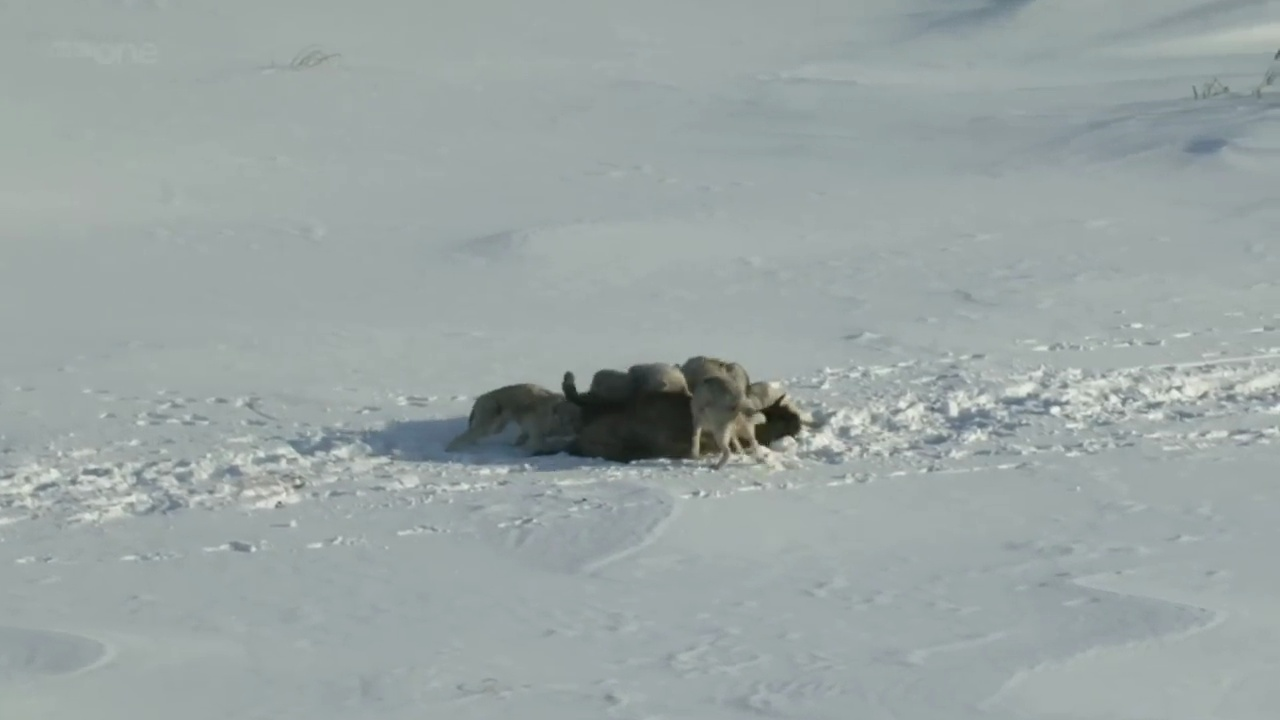

In [8]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [10]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Sure, here's a description you could use for your video:

"Experience the raw intensity of nature with this breathtaking footage showcasing the life-and-death struggle in the wild. Witness a pack of wolves in their element, strategically coordinating an attack on a formidable bison in the frigid expanse of a winter landscape. Every frame captures the stark beauty of the snowy environment, while portraying the harsh realities of survival in the animal kingdom. This video offers a glimpse into the remarkable behaviors of these wild creatures, navigating the delicate balance of predator and prey. A must-watch for wildlife enthusiasts and nature lovers alike. Don't miss this epic encounter recorded from the front lines of the wilderness."

This description aims to engage potential viewers by hinting at the dramatic content of your video, without giving everything away, and encourages viewers to watch the encounter unfold.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [11]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Beneath the vast canvas of a winter sky, a drama unfolds on the crisp, snow-covered plains. Here, we see the eternal struggle for survival played out between the cunning wolf pack and the imposing bison. The wolves, agile and relentless, work in unity, each member keenly aware of its role in this life-or-death ballet. The bison, a goliath of the prairie, stands its ground with formidable presence and strength that have protected its kind for millennia.

As the wolves circle, their strategic minds calculate the precise moment to strike, the interplay of predator and prey, an intricate dance that keeps the fragile balance of this ecosystem. The bison, outnumbered but not outmatched, uses its sheer mass and power to fend off the assailants, its every breath sending clouds of steam into the icy air, as if the very essence of life itself were entwined with the frost that surrounds them.

In such wild encounters, there are no guaranteed outcomes. Each movement can alter the conclusion of thi

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [12]:
from pathlib import Path
client = OpenAI()

speech_file_path = Path(__file__).parent / "output.mp3"
response = client.audio.speech.create(
  model="tts-1",
  voice="onyx",
  input=result.choices[0].message.content
)

response.with_streaming_response.method(speech_file_path)

Audio("output.mp3")